# 08. Milestone Project 2: PyTorch Paper Replicating

The goal of machine learning research paper replicating is: turn a ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch: 

https://arxiv.org/abs/2010.11929

## 0. Get Setup

Let's import code we've previously written + required libraries

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
torch version: 2.5.1
torchvision version: 0.20.1


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

/Users/mdashikadnan/Documents/adnanedu/python/ztm/pytorch/pytorch-ztm/pytorch-deep-learning/pytorch_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Setup device agnostic code
def set_device():

    if torch.cuda.is_available():

        device = torch.device("cuda")

    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():

        device = torch.device("mps")

    else:

        device = torch.device("cpu")

    return device

device = set_device()
print(f"Using device: {device}")

Using device: mps


## 1. Get Data

The whole goal of what we're trying to do is to replicate the ViT architecture for our FoodVision Mini problem.

To do that, we need some data.

Namely, the pizza, steak and sushi images we've been using so far.

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [7]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size 
IMG_SIZE = 224 # comes from Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
                                        transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                        transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
# Create a batch size of 32 (gthe paper uses 4096 but this may be too big for our smaller hardware... can always scale up later)
BATCH_SIZE = 32 

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

## 2.3 Visualize a single image

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

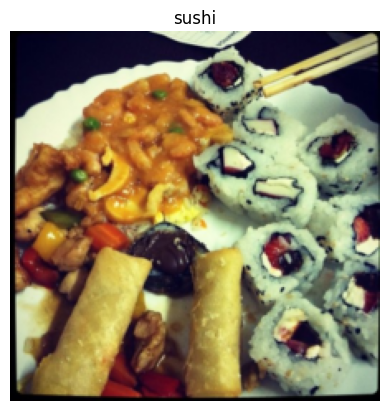

In [10]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0)) # (color_channels, height, width) -> (height, width, color_channels)
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT: Overview

Looking at a whole machine learning research paper can be imtimidating.

So in order to make it more understandable, we can break it down into smaller pieces:

* **Inputs** - What goes into the model? (in our case, image tensors)

* **Outputs** - What comes out of the model/layer/block? (in our case, we want the model to output image classification labels)

* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention).

* **Blocks** - A collection of layers.

* **Model** (or architecture) - A collection of blocks.

### 3.1 ViT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for the architecture/training.
* Text descriptions (especially section 3.1)

### Figure 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from vision transformer paper">

* Embedding = learnable representation (start with random numbers and improve over time)

### Four equations

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/08-vit-paper-four-equations.png" width=600 alt="four equations from vision transformer paper"/>


Section 3.1:

#### Section 3.1 describes the various equations:

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```

---

**Equations 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:

```python
# Equation 2 
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3 
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block 
```
---


**Equation 4:**
Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_{L}^{0}$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time 

In pseudocode:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block)) 
```

### Table 1 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt="table 1 from vision transformer paper"/>

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture
* ViT-B/16 = ViT-Base with image patch size 16x16 
* Layers - the number of transformer encoder layers 
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/neurons in the MLP
* Heads - the number of multi-head self-attention 


## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) -> single image -> (height, width, color channels)
* Output shape: ???

### 4.1 Calculate input and output shapes by hand

> **Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

> **Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input shape: $H\times{W}\times{C}$ (height x width x color channels)
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / p^2
* D = constant latent vector size = embedding dimension (see Table 1)


In [11]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [12]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


### 4.2 Turning a single image into patches

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

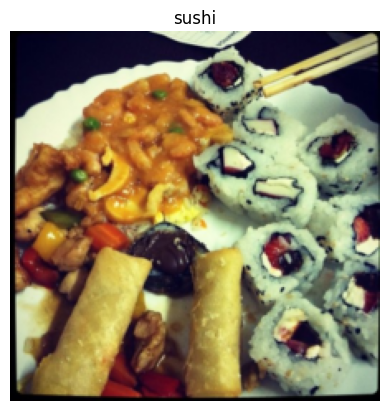

In [13]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

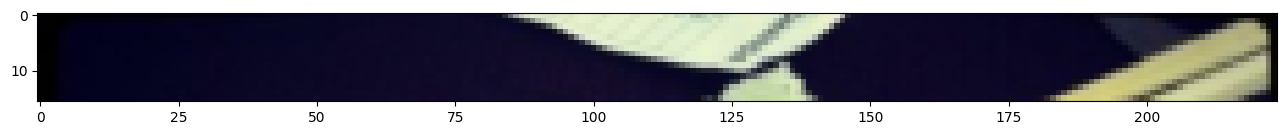

In [14]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # convert image to color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]) # (H, W, C) Consider H -> 16 

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


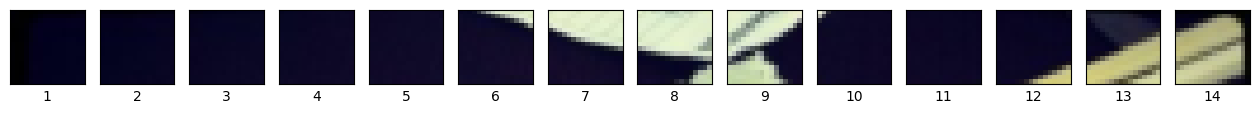

In [15]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); 
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0  
Number of patches per column: 14.0  
Total patches: 196.0  
Patch size: 16 pixels x 16 pixels


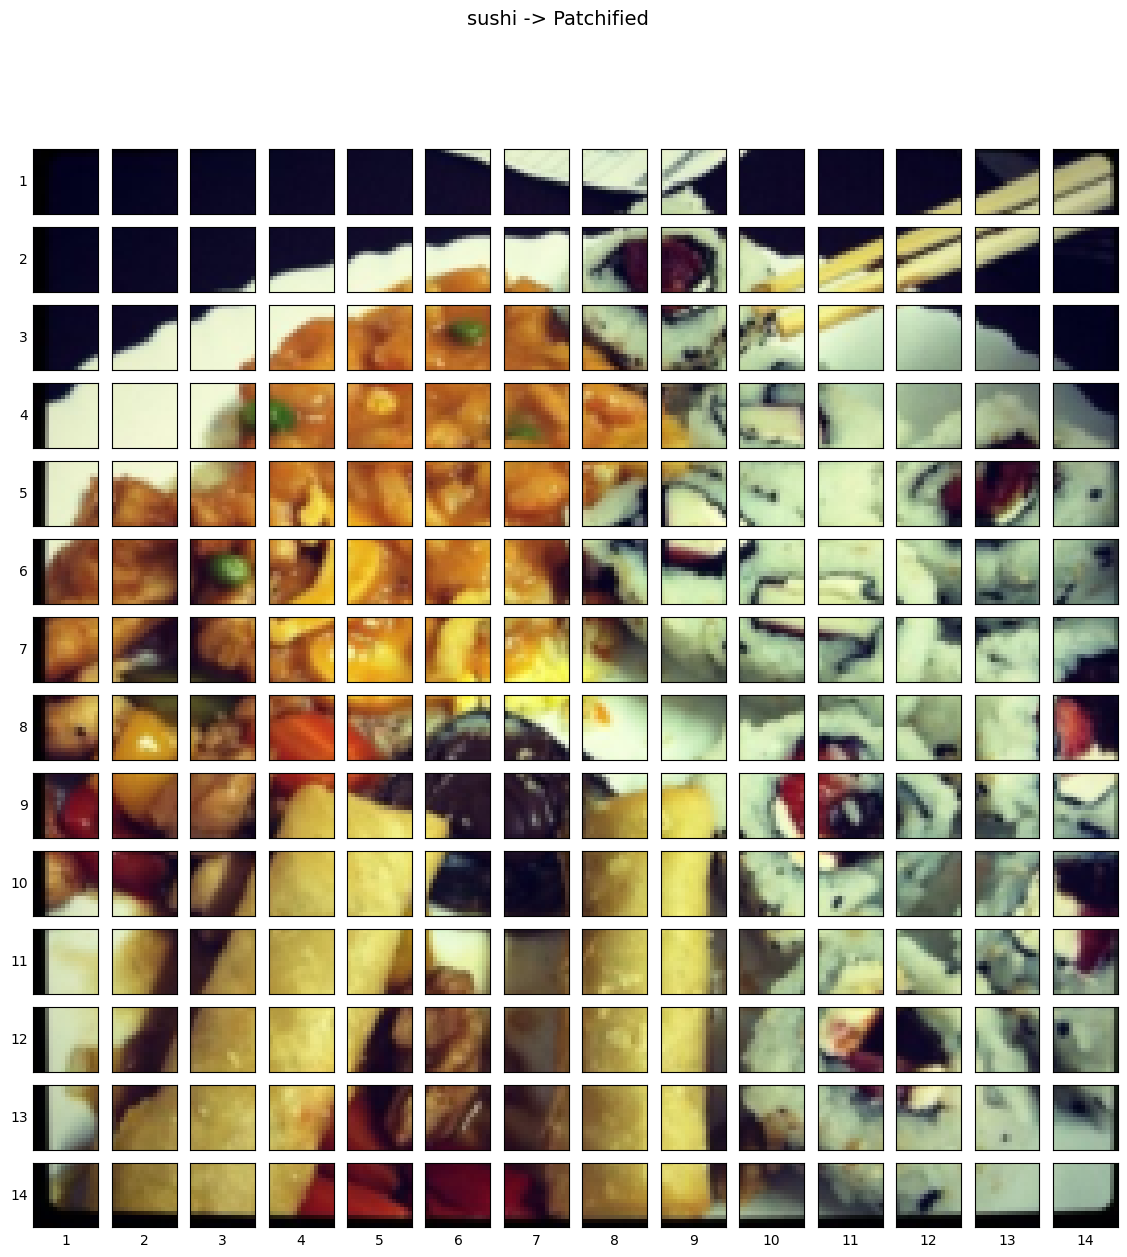

In [16]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

print(f"Number of patches per row: {num_patches}\
  \nNumber of patches per column: {num_patches}\
  \nTotal patches: {num_patches*num_patches}\
  \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # Plot the permuted image on the different axes 
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                    patch_width:patch_width+patch_size, # iterate through width
                                    :]) # get all color channels
    # Set up label information for each subplot (patch)
    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Set up a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

### 4.3 Creating image patches and turning them into patch embeddings

Perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`. 


In [17]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the VIP paper
conv2d = nn.Conv2d(in_channels=3, # for color images
                   out_channels=768, # D size from Table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

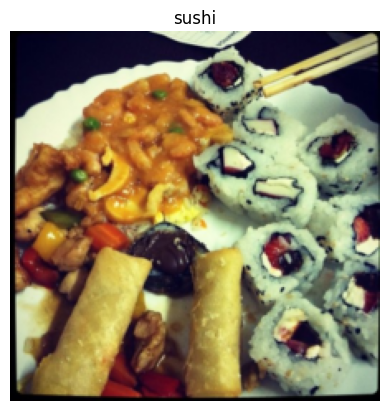

In [18]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [19]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # Add batch dimension -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [20]:
image_out_of_conv.requires_grad

True

Now we've passed a single image to our `conv2d` layer, it's shape is: 

```python
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width] 
```

Showing random convolutional feature maps from indexes: [683, 77, 245, 98, 4]


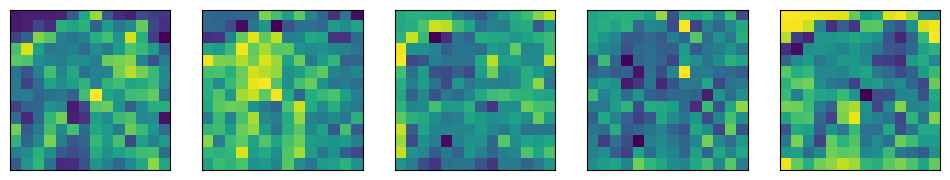

In [21]:
# plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot 
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [22]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :] 
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0532,  0.0389,  0.0379,  0.0282,  0.0282, -0.1439, -0.3665,
           -0.3217, -0.2061, -0.0260,  0.0296, -0.0287,  0.1749,  0.0498],
          [ 0.0544,  0.0342, -0.0109,  0.1875,  0.0921, -0.0478,  0.0163,
           -0.3995, -0.2185, -0.0148,  0.1243, -0.2265, -0.3853,  0.0206],
          [-0.0289,  0.2525, -0.2304, -0.4448, -0.1882, -0.0955, -0.1958,
           -0.1793, -0.0709, -0.1706, -0.2020, -0.1376,  0.0099,  0.0163],
          [ 0.0531, -0.2659, -0.4517, -0.1661, -0.2387, -0.1641, -0.2432,
           -0.1805,  0.1121, -0.0603, -0.2092, -0.1650, -0.1664,  0.0854],
          [-0.1642, -0.3493, -0.2044, -0.0681, -0.1987, -0.1511, -0.2744,
           -0.1227, -0.0869, -0.1692, -0.2545, -0.0700,  0.0814, -0.1436],
          [-0.2254, -0.0560,  0.0072, -0.2361, -0.2704, -0.2246, -0.1605,
            0.0183, -0.0077, -0.3125, -0.2246, -0.2602, -0.1912, -0.1935],
          [-0.2907, -0.1028, -0.2909, -0.3573, -0.2295, -0.3660, -0.1517,
           -0.0526, -0.2306, -0.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we've a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of the ViT Transformer Encoder.

In [23]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


Want: (batch_size, number_of_patches, embedding_dim)

In [24]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


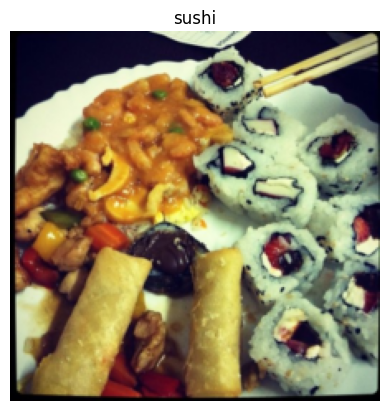

In [25]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [26]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


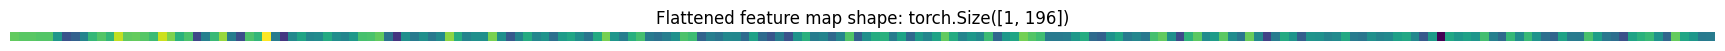

In [27]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0] # One of our image is represented by 768 flatten embedding vectors

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False); 

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:
1. Create a class called `PatchEmbedding` that inherits from `nn.Module`.
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedded patches using `nn.Conv2d()`.
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `foward()` that defines the forward computation (e.g. pass through layer from 3 and 4).
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [28]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768  # From Table 1 for VIT-Base
                 ):
        super().__init__()
        self.patch_size = patch_size

        # Create the layer to turn an image into embedded patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # Create a layer to flatten feature map outputs of Conv2d
        self.flatten = nn.Flatten(start_dim=2,
                                   end_dim=3)

    # Define a forward method to define the forward computation steps
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        # Make the return sequence embedding dimensions are in the right order (batch_size, number_of_patches, embedding_dimension)
        return x_flattened.permute(0, 2, 1) 


In [29]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)

# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # Add an extra batch dimension
print(f"Output patch embedding sequence shape {patch_embedded_image.shape}")


Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape torch.Size([1, 196, 768])


In [30]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

# patchify(rand_image_tensor_bad)

### 4.6 Creating the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding.

In [31]:
patch_embedded_image

tensor([[[-5.7291e-02, -8.7825e-03, -6.9066e-02,  ...,  2.7077e-02,
           1.9915e-02,  1.0614e-02],
         [-6.1664e-02, -2.6245e-04, -4.3854e-02,  ...,  4.8030e-02,
          -5.4146e-03,  2.6753e-03],
         [-7.1160e-02,  9.5417e-03, -4.6811e-02,  ...,  5.4685e-02,
          -1.6440e-02,  1.5286e-02],
         ...,
         [-5.1426e-01,  1.5813e-01,  3.3814e-02,  ...,  2.4245e-01,
          -3.1692e-01,  5.8773e-02],
         [-6.1971e-01,  1.3668e-01,  7.5848e-02,  ...,  3.2162e-01,
          -2.1575e-01,  1.5112e-01],
         [-5.1489e-01, -1.2918e-01,  1.0141e-01,  ...,  1.9919e-01,
          -1.2740e-01,  8.8478e-02]]], grad_fn=<PermuteBackward0>)

In [32]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [33]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [34]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [35]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1) # number_of_patches dimension
print(patch_embedded_image_with_class_embedding) 

print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)")

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-5.7291e-02, -8.7825e-03, -6.9066e-02,  ...,  2.7077e-02,
           1.9915e-02,  1.0614e-02],
         [-6.1664e-02, -2.6245e-04, -4.3854e-02,  ...,  4.8030e-02,
          -5.4146e-03,  2.6753e-03],
         ...,
         [-5.1426e-01,  1.5813e-01,  3.3814e-02,  ...,  2.4245e-01,
          -3.1692e-01,  5.8773e-02],
         [-6.1971e-01,  1.3668e-01,  7.5848e-02,  ...,  3.2162e-01,
          -2.1575e-01,  1.5112e-01],
         [-5.1489e-01, -1.2918e-01,  1.0141e-01,  ...,  1.9919e-01,
          -1.2740e-01,  8.8478e-02]]], grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)


### 4.7 Creating the position embedding

Want to: create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings.

In [36]:
# Calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)
position_embedding, position_embedding.shape


(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [37]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
            1.0000e+00,  1.0000e+00],
          [-5.7291e-02, -8.7825e-03, -6.9066e-02,  ...,  2.7077e-02,
            1.9915e-02,  1.0614e-02],
          [-6.1664e-02, -2.6245e-04, -4.3854e-02,  ...,  4.8030e-02,
           -5.4146e-03,  2.6753e-03],
          ...,
          [-5.1426e-01,  1.5813e-01,  3.3814e-02,  ...,  2.4245e-01,
           -3.1692e-01,  5.8773e-02],
          [-6.1971e-01,  1.3668e-01,  7.5848e-02,  ...,  3.2162e-01,
           -2.1575e-01,  1.5112e-01],
          [-5.1489e-01, -1.2918e-01,  1.0141e-01,  ...,  1.9919e-01,
           -1.2740e-01,  8.8478e-02]]], grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [38]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9427, 0.9912, 0.9309,  ..., 1.0271, 1.0199, 1.0106],
         [0.9383, 0.9997, 0.9561,  ..., 1.0480, 0.9946, 1.0027],
         ...,
         [0.4857, 1.1581, 1.0338,  ..., 1.2425, 0.6831, 1.0588],
         [0.3803, 1.1367, 1.0758,  ..., 1.3216, 0.7843, 1.1511],
         [0.4851, 0.8708, 1.1014,  ..., 1.1992, 0.8726, 1.0885]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


### 4.8 Putting it all together: from image to embedding

We've written code to turn an image into a flattened sequence of patch embeddings.

Now let's it all in one cell.

In [39]:
set_seeds()

patch_size = 16

print(f"Image tensor shape: {image.shape}")

height, width = image.shape[1], image.shape[2]

# Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# Pass input image through patch embedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[2]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

# Prepend the class token embedding to the patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(batch_size, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## 5. Equation 2: Multihead Self-Attention (MSA block)

* **Multihead self-attention** = which part of a sequence should pay the most attention to itself?
  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
  * We want our neural network (ViT) to learn this relationship/representation.
* To replicate MSA in PyTorch we can use: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html 

* **LayerNorm** = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
  * Normalization = make everything have the same mean and same standard deviation.
  * In PyTorch = https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html, normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension. 
    * When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size.

In [40]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """
        Create a multi-head self-attention block ("MSA block" for short)
    """
    def __init__(self, 
                 embedding_dim:int=768, # Hidden size D (embedding dimension) from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:int=0):
        super().__init__()

        # Create the norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create multihead attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, 
                                                    dropout=attn_dropout,
                                                    batch_first=True) # # is the batch first? (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)
        
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)
        return attn_output

In [41]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768, num_heads=12, attn_dropout=0)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)

print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


## 6. Equation 3: Multilayer Perceptron (MLP block)

* **MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1).
  * MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer. 
  * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch, they're often called `torch.nn.Linear()` and in TensorFlow they might be called `tf.keras.layers.Dense()`
  * GELU in PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.GELU.html#torch.nn.GELU 
  * MLP number of hidden units = MLP Size in Table 1
* **Dropout** =  Dropout, when used, is applied after
every dense layer except for the the qkv-projections and directly after adding positional- to patch
embeddings. Hybrid models are trained with the exact setup as their ViT counterparts. 
  * Value for Dropout available in Table 3 

In pseudocode:

```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

In [42]:
class MLPBlock(nn.Module):
    def __init__(self, embedding_dim:int=768, mlp_size:int=3072, dropout:int=0.1):
        super().__init__()

        # Create the norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the MLP
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        return self.mlp(self.layer_norm(x))

In [43]:
 # Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output of the MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


## 7. Creating the Transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).

And there are residual connections between each block.

* Encoder = turn a sequence into learnable representation
* Decoder = go from learn representation back to some sort of sequence
* Residual connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks (prevents weights from getting too small)

In pseudocode:

```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ... 
```

### 7.1 Create a custom Transformer Encoder block

In [44]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, 
                 embedding_dim:int=768, # Hidden size D from table 1, 768 for ViT-Base
                 num_heads:int=12, # from table 1
                 mlp_size:int=3072, # from table 1
                 mlp_dropout:int=0.1, # from table 3
                 attn_dropout:int=0):
        super().__init__()

        # Create MSA block (equation 2)
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # Create MLP block (equation 3)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)
        
    def forward(self, x):
        x = self.msa_block(x) + x # residual/skip connection for equation 2
        x = self.mlp_block(x) + x # residual/skip connection for equation 3
        return x

In [45]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a Transformer Encoder layer with in-built PyTorch layers

So far we've created a transformer encoder by hand.

But because of how good the Transformer architecture is, PyTorch has implemented ready to use Transformer Encoder layers: https://pytorch.org/docs/stable/nn.html#transformer-layers 

We can create a Transformer Encoder with pure PyTorch layers: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer 

In [46]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embedding size from table 1
                                                             nhead=12, # heads from table 1
                                                             dim_feedforward=3072, # MLP size from table
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [47]:
# Get a summary using torchinfo.summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

## 8. Putting it all together to create ViT

### Expand class token embedding across every image in a batch

Since we are going to pass batches of images in our batch model.

We want to create class token each image in a batch.

In [48]:
batch_size = 32
embedding_dim = 768

class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)
print(class_embedding.shape)
print(class_embedding_expanded.shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [49]:
# Create a ViT class 
class ViT(nn.Module): 
    def __init__(self,
               img_size:int=224, # Table 3 from the ViT paper
               in_channels:int=3,
               patch_size:int=16, 
               num_transformer_layers:int=12, # Table 1 for "Layers" for ViT-Base -> Layers refers to number of transformers encoder blocks -> Turned them into a PyTorch code blocks
               embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
               mlp_size:int=3072, # Table 1 -> Hidden unit size within MLP
               num_heads:int=12, # Table 1
               attn_dropout:int=0,
               mlp_dropout:int=0.1, # Randomly remove connection between layers to make the remaining connection better
               embedding_dropout:int=0.1, # Dropout for patch and position embeddings
               num_classes:int=1000): # number of classes in our classification problem
        super().__init__()

        # Make an assertion that the image size is compatible with the patch size
        assert img_size % patch_size == 0,  f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"

        # Calculate the number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # Create learnable position embedding 
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))


        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout) # When used -> Directly after adding positional- to patch embeddings. 

            # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                            patch_size=patch_size,
                                            embedding_dim=embedding_dim)


        # Create the Transformer Encoder block
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                        num_heads=num_heads,
                                                                        mlp_size=mlp_size,
                                                                        mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        
        # Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                    out_features=num_classes)
        )

    def forward(self, x):
        # Get the batch size
        batch_size = x.shape[0]


        # Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # '-1' means to infer the dimension

        # Create the patch embedding (equation 1)
        x = self.patch_embedding(x)

        # Concat class token embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches, embedding_dim)

        # Add position embedding to class token and patch embedding
        x = self.position_embedding + x

        # Apply dropout to patch embedding ("directly after adding positional- to patch embeddings") -> B.1 TRAINING
        x = self.embedding_dropout(x)

        # Pass position and patch embedding to Transformer Encoder (equation 2 & 3)
        x = self.transformer_encoder(x)

        # Put 0th index logit through classifier (equation 4)
        x = self.classifier(x[:, 0])

        return x 


In [50]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak and sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(rand_image_tensor)

tensor([[0.2786, 0.8428, 1.1764]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of our ViT model

In [51]:
from torchinfo import summary

summary(model=ViT(num_classes=len(class_names)),
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## 9. Setting up training code for our custom ViT

We've replicated the ViT architecture, now let's see how it performs on our FoodVision Mini data.

### 9.1 Creating an optimizer

The paper states it uses the Adam optimizer (section 4, Training & fine-tuning) with $B1$ value of 0.9, $B2$ of 0.999 (defaults) and a weight decay of 0.1.

Weight decay = Weight decay is a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function. 

Regularization technique = prevents overfitting.

In [52]:
optimizer = torch.optim.Adam(vit.parameters(), lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

### 9.2 Creating a loss function

The ViT paper doesn't actually mention what loss function they used.

So since it's a multi-class classification we'll use the `torch.nn.CrossEntropyLoss()`.

In [53]:
loss_fn = torch.nn.CrossEntropyLoss()

### 9.3 Training our ViT Model

In [54]:
device

device(type='mps')

In [55]:
from going_modular.going_modular import engine

set_seeds()

optimizer = torch.optim.Adam(vit.parameters(), lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)


loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model=vit, 
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

 10%|█         | 1/10 [01:24<12:37, 84.20s/it]

Epoch: 1 | train_loss: 4.7328 | train_acc: 0.3008 | test_loss: 1.0584 | test_acc: 0.5417


 20%|██        | 2/10 [02:47<11:10, 83.83s/it]

Epoch: 2 | train_loss: 1.5878 | train_acc: 0.2812 | test_loss: 1.5407 | test_acc: 0.1979


 30%|███       | 3/10 [04:13<09:51, 84.56s/it]

Epoch: 3 | train_loss: 1.4640 | train_acc: 0.2617 | test_loss: 1.3416 | test_acc: 0.1979


 40%|████      | 4/10 [05:37<08:25, 84.29s/it]

Epoch: 4 | train_loss: 1.2656 | train_acc: 0.2852 | test_loss: 1.8904 | test_acc: 0.1979


 50%|█████     | 5/10 [07:01<07:01, 84.21s/it]

Epoch: 5 | train_loss: 1.3560 | train_acc: 0.2773 | test_loss: 1.5892 | test_acc: 0.2604


 60%|██████    | 6/10 [08:27<05:39, 84.91s/it]

Epoch: 6 | train_loss: 1.2429 | train_acc: 0.3125 | test_loss: 1.9387 | test_acc: 0.1979


 70%|███████   | 7/10 [09:51<04:13, 84.58s/it]

Epoch: 7 | train_loss: 1.2140 | train_acc: 0.4180 | test_loss: 3.8343 | test_acc: 0.1979


 80%|████████  | 8/10 [11:15<02:48, 84.46s/it]

Epoch: 8 | train_loss: 1.5315 | train_acc: 0.2812 | test_loss: 1.6836 | test_acc: 0.2604


 90%|█████████ | 9/10 [12:42<01:25, 85.28s/it]

Epoch: 9 | train_loss: 1.4959 | train_acc: 0.2500 | test_loss: 1.3974 | test_acc: 0.5417


100%|██████████| 10/10 [14:06<00:00, 84.65s/it]

Epoch: 10 | train_loss: 1.5848 | train_acc: 0.2656 | test_loss: 1.1346 | test_acc: 0.2604


### 9.4 What our training setup is missing

How is our training setup different to the ViT paper? 

We've replicated model archirecture correctly.

But what was different between our training procedure (to get such poor results) and the ViT paper training procedure to get such great results?

The main things our training implementation is missing: 

Prevent underfitting:
* Data - our setup uses far less data (225 vs millions)

Prevent overfitting: 
* Learning rate warmup - start with a low learning rate and increase to a base LR
* Learning rate decay - as your model gets closer to convergence, start to lower the learning rate 
* Gradient clipping - prevent gradients from getting too big 

Search "pytorch [technique name]" 

### 9.5 Plotting loss curves for our model

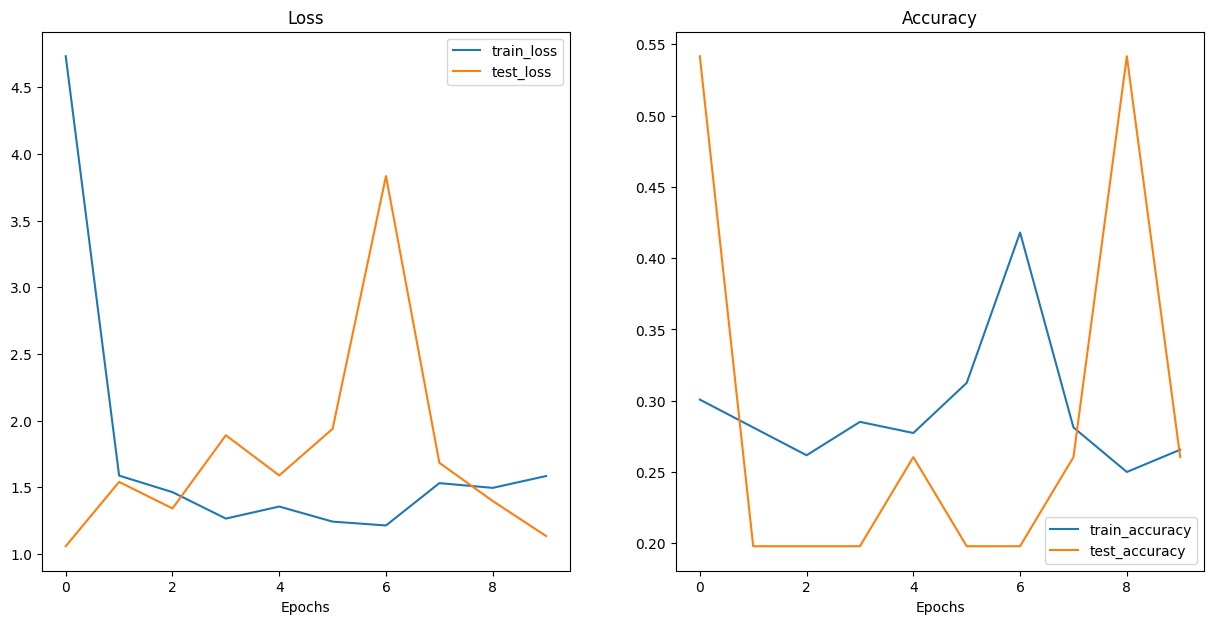

In [56]:
from helper_functions import plot_loss_curves

plot_loss_curves(results) 

Hmm it looks like our model is underfitting and overfitting... I wonder what techniques we could use to take care of both at the same time?

## 10. Using a pretrained ViT from `torchvision.models`

Generally, in deep learning if you can use a pretrained model from a large dataset on your own problem, it's often a good place to start.

If you can find a pretrained model and use transfer learning, give it a go, it often achieves great results with little data.

### 10.1 Why use a pretrained model?

* Sometimes data is limited
* Limited training resources
* Get better results faster (sometimes)...

In [57]:
# The following requires torch v0.12+ and torchvision 0.13+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.5.1
0.20.1


In [58]:
device

device(type='mps')

### 10.2 Prepare a pretrained ViT for use with FoodVision Mini (turn it into a feature extractor)

In [59]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" = best available

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Update the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [60]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.3 Preparing data for the pretrained ViT model

When using a pretrained model, you want to make sure your data is formatted in the same way that the model was trained on. 

In [61]:
# Get automatic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [62]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [63]:
# Setup dataloaders
from going_modular.going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32) # could set a higher batch size because using a pretrained model 

### 10.4 Train feature extractor ViT model

In [64]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

 10%|█         | 1/10 [01:14<11:14, 75.00s/it]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769


 20%|██        | 2/10 [02:29<09:56, 74.62s/it]

Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977


 30%|███       | 3/10 [03:43<08:42, 74.63s/it]

Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186


 40%|████      | 4/10 [04:59<07:29, 74.84s/it]

Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186


 50%|█████     | 5/10 [06:13<06:12, 74.58s/it]

Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977


 60%|██████    | 6/10 [07:27<04:57, 74.31s/it]

Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280


 70%|███████   | 7/10 [08:40<03:41, 73.92s/it]

Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883


 80%|████████  | 8/10 [09:55<02:28, 74.29s/it]

Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081


 90%|█████████ | 9/10 [11:09<01:14, 74.18s/it]

Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384


100%|██████████| 10/10 [12:22<00:00, 74.28s/it]

Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### 10.5 Plot the loss curves of our pretrained ViT feature extractor model

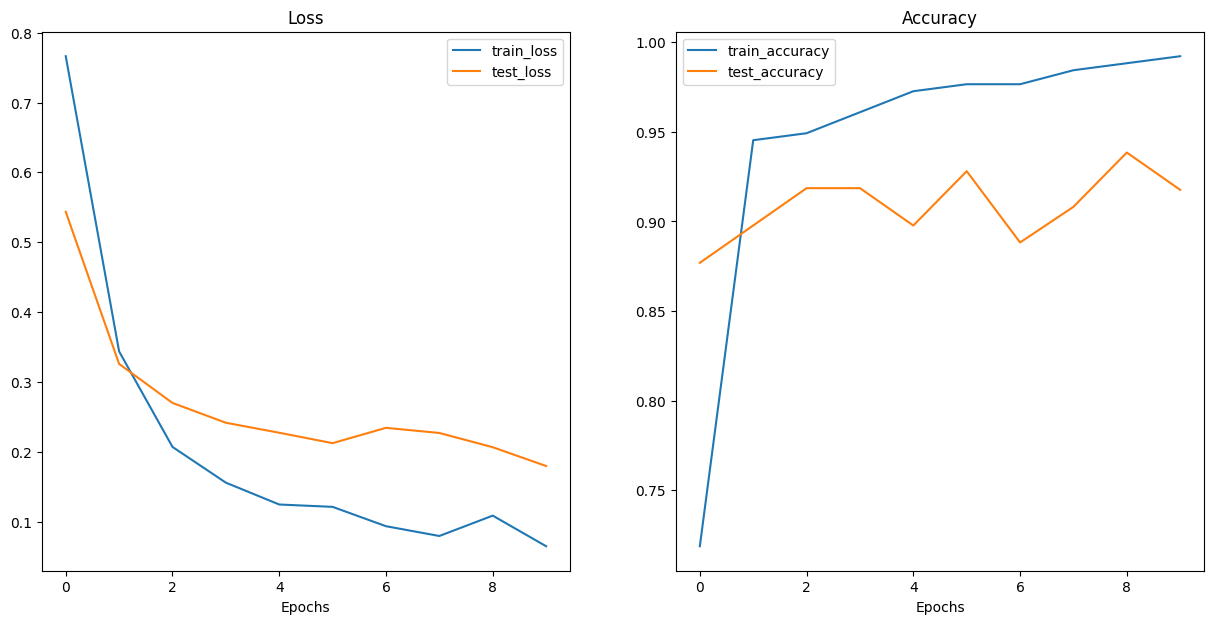

In [65]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6 Save our best performing ViT model

Now we've got a model that performs quite well, how about we save it to file and then check it's filesize.

We want to check the filesize because if we wanted to deploy a model to say a website/mobile application, we may limitations on the size of the model we can deploy.

E.g. a smaller model may be required due to compute restrictions.

In [66]:
# # Save the model
# from going_modular.going_modular import utils

# utils.save_model(model=pretrained_vit,
#                  target_dir="models",
#                  model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

In [67]:
# from pathlib import Path

# # Get the model size in bytes then convert to megabytes 
# pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)
# print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

## 11. Predicting on a custom image

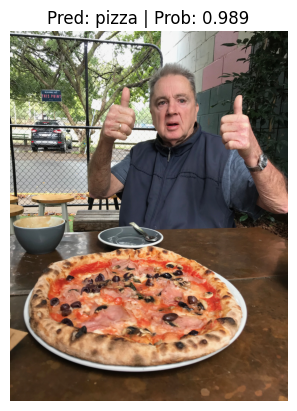

In [68]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)